In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [2]:
data_path = "C:/Users/emreh/Desktop/Tüm Dosyalar/S2T/LJSpeech"

In [3]:
data = pd.read_csv("metadata2.csv")

In [4]:
wavs_path = data_path + "/wavs/"

In [5]:
data.head(3)

,file_name,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...


##### test datası ve eğitiim datasının bölünmesi

In [6]:
split = int(len(data)*0.90) #tüm verinin büyüklüğünü alıp %90'ını eğitim, %10'unu test için ayırdım
train_df = data[:split]
test_df = data[split:]

print(f"Eğitim veri setinin büyüklüğü: {len(train_df)}")
print(f"Test veri setinin büyüklüğü: {len(test_df)}")

Eğitim veri setinin büyüklüğü: 11790
Test veri setinin büyüklüğü: 1310


In [7]:
train_df

,file_name,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
11785,LJ045-0235,the testimony of the officers present indicate...
11786,LJ045-0236,He admitted nothing that would damage him but ...
11787,LJ045-0237,"His denials under questioning, which have no p..."
11788,LJ045-0238,and in the face of the overwhelming evidence a...


###### ön işleme

In [8]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "] #burada ingilizce olan tüm karakterleri liste içinde tuttum

In [9]:
char_to_int = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary = characters,
                                       oov_token="")

int_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=char_to_int.get_vocabulary(), 
                                                                      oov_token="",
                                                                      invert=True)

In [10]:
char_to_int("c") 

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [11]:
int_to_char(4)

<tf.Tensor: shape=(), dtype=string, numpy=b'c'>

In [28]:
frame_length = 256
frame_step = 160
fft_length = 384
def encode_single_sample(wav_file,label):
    file = tf.io.read_file(wav_file+".wav")
    
    audio,_ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio,axis=-1)
    
    audio = tf.cast(audio,tf.float32)
    
    spectrogram = tf.signal.stft(audio,frame_length=frame_length,
                                frame_step=frame_step, fft_length=fft_length)
    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    
    means = tf.math.reduce_mean(spectrogram,1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram,1, keepdims=True)
    spectrogram = (spectrogram- means) / (stddevs +1e-10)
    
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label,input_encoding= "UTF-8")
    
    label = char_to_int(label)
    
    return spectrogram, label

In [29]:
wav=train_df.loc[0,"file_name"]
label= train_df.loc[0,"normalized_transcription"]
wav,label

('LJ001-0001',
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition')

In [30]:
audio = wavs_path+wav

In [31]:
audio

'C:/Users/emreh/Desktop/Tüm Dosyalar/S2T/LJSpeech/wavs/LJ001-0001'

In [32]:
spectrogram, label= encode_single_sample(audio,label)

In [33]:
label

<tf.Tensor: shape=(151,), dtype=int64, numpy=
array([17, 19, 10, 15, 21, 10, 15,  8,  1, 31, 10, 15, 31, 21,  9,  6, 31,
       16, 15, 13, 26, 31, 20,  6, 15, 20,  6, 31, 24, 10, 21,  9, 31, 24,
        9, 10,  4,  9, 31, 24,  6, 31,  2, 19,  6, 31,  2, 21, 31, 17, 19,
        6, 20,  6, 15, 21, 31,  4, 16, 15,  4,  6, 19, 15,  6,  5,  1, 31,
        5, 10,  7,  7,  6, 19, 20, 31,  7, 19, 16, 14, 31, 14, 16, 20, 21,
       31, 10,  7, 31, 15, 16, 21, 31,  7, 19, 16, 14, 31,  2, 13, 13, 31,
       21,  9,  6, 31,  2, 19, 21, 20, 31,  2, 15,  5, 31,  4, 19,  2,  7,
       21, 20, 31, 19,  6, 17, 19,  6, 20,  6, 15, 21,  6,  5, 31, 10, 15,
       31, 21,  9,  6, 31,  6, 25,  9, 10,  3, 10, 21, 10, 16, 15],
      dtype=int64)>

printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the exhibition


tf.Tensor(
[17 19 10 15 21 10 15  8  1 31 10 15 31 21  9  6 31 16 15 13 26 31 20  6
 15 20  6 31 24 10 21  9 31 24  9 10  4  9 31 24  6 31  2 19  6 31  2 21
 31 17 19  6 20  6 15 21 31  4 16 15  4  6 19 15  6  5  1 31  5 10  7  7
  6 19 20 31  7 19 16 14 31 14 16 20 21 31 10  7 31 15 16 21 31  7 19 16
 14 31  2 13 13 31 21  9  6 31  2 19 21 20 31  2 15  5 31  4 19  2  7 21
 20 31 19  6 17 19  6 20  6 15 21  6  5 31 10 15 31 21  9  6 31  6 25  9
 10  3 10 21 10 16 15], shape=(151,), dtype=int64)


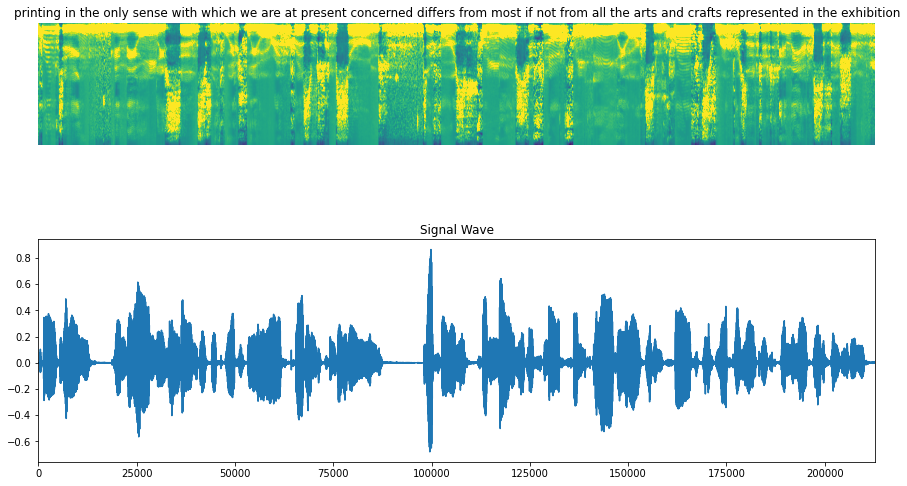

In [34]:
fig = plt.figure(figsize=(15, 9))
spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
# Spectrogram

text = tf.strings.reduce_join(int_to_char(label)).numpy().decode("utf-8")
print(text)
print("\n")
print(label)

ax = plt.subplot(2, 1, 1)
ax.imshow(spectrogram, vmax=1)
ax.set_title(text)
ax.axis("off")

# Wav
file = tf.io.read_file(audio+".wav")
audio, _ = tf.audio.decode_wav(file)
audio = audio.numpy()
ax = plt.subplot(2, 1, 2)
plt.plot(audio)
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()